<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/mlops/profit-curves/decision_simulation_cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wandb/edu/blob/main/decision-opt-course/assignment/start_here.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{decisionopt-assignment} -->

# Your Mission
<!--- @wandbcode{decisionopt-assignment} -->

Your mission, should you choose to accept it, is to write a python function that will determine when a large manufacturer repairs their machines and when they let them run unrepaired 🙏🏻

You will use data from Kaggle's [Classication of Machine Failures](https://www.kaggle.com/competitions/playground-series-s3e17) competition. The original data doesn't include economic information like the cost of repairing a machine. This information is described in this assignment and you will code it in your simulation (the original data was also synthetically generated, so it was generated with a similar process).

You will

1. Write a function that calculates maintenance and repair costs when you use any supplied decision function for determining when to do machine maintenance
2. Create 3 decision functions and compare their costs using the function you just wrote in step 1
3. Write and share a Weights & Biases report so your colleagues can see the implications of using your preferred decision function. In your report, describe (in just a few sentences):
  - How you might deal with potential covariate shift if training data was collected in winter when air temperatures are lower, so you expect future air temperatures to be warmer
  - How you might test your decision function in reality to make sure it works before applying it at scale

# Data

In [122]:
# Uncomment if you're on Google Colab
!mkdir data
!wget -P data https://raw.githubusercontent.com/wandb/edu/main/decision-opt-course/assignment/data/train.csv
!pip install wandb -qqq

mkdir: cannot create directory ‘data’: File exists
--2025-05-03 18:13:54--  https://raw.githubusercontent.com/wandb/edu/main/decision-opt-course/assignment/data/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7181150 (6.8M) [text/plain]
Saving to: ‘data/train.csv.5’

train.csv.5         100%[===================>]   6.85M  --.-KB/s    in 0.07s   

2025-05-03 18:13:54 (103 MB/s) - ‘data/train.csv.5’ saved [7181150/7181150]



In [123]:
import numpy as np
import pandas as pd

data = pd.read_csv('data/train.csv')
data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


Note: TWF, HDF, PWF, OSF and RNF are different types of failures (eg tool wear, heat dissipation, power wear, overstrain and random failures respectively). You will decide whether to repair a machine before the failure, and thus before you would know `Machine failure` or any of the failure type information

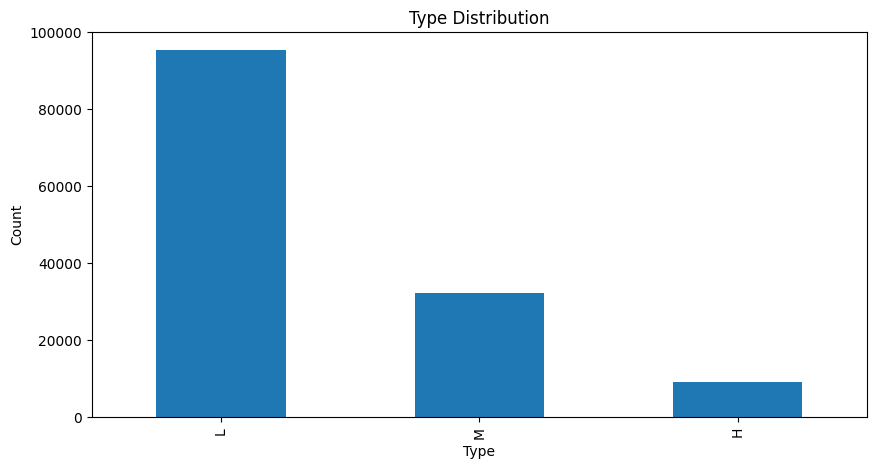

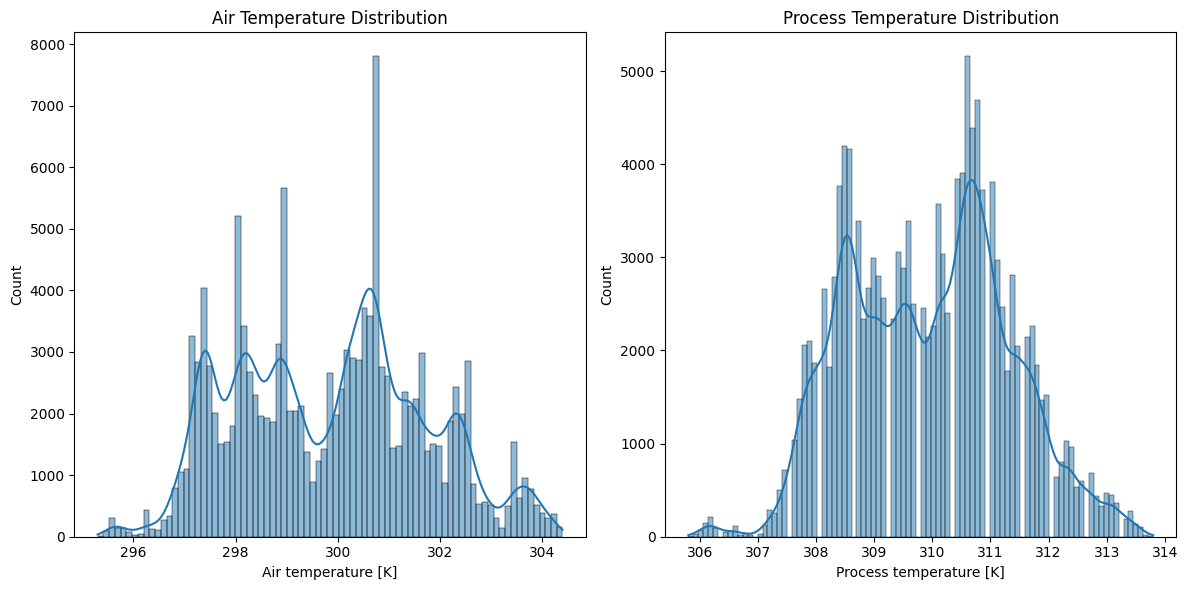

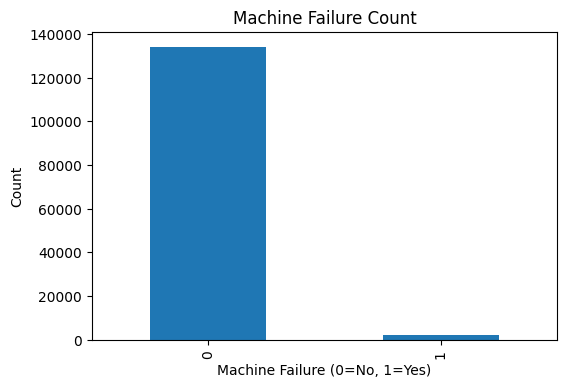

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


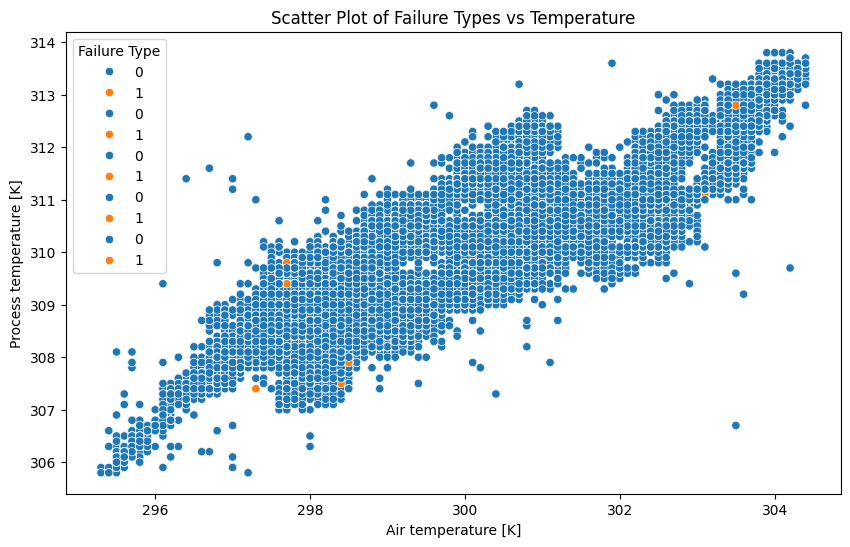

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Unique Product ID Count
# product_id_counts = data['Product ID'].value_counts()
# plt.figure(figsize=(10, 5))
# sns.countplot(x='Product ID', data=data)
# plt.title('Unique Product ID Count')
# plt.xticks(rotation=45)
# plt.show()

# Type Distribution
plt.figure(figsize=(10, 5))
data['Type'].value_counts().plot(kind='bar')
plt.title('Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()


# Temperature Ranges (Air and Process)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['Air temperature [K]'], kde=True)
plt.title('Air Temperature Distribution')

plt.subplot(1, 2, 2)
sns.histplot(data['Process temperature [K]'], kde=True)
plt.title('Process Temperature Distribution')

plt.tight_layout()
plt.show()


# Machine Failure Count
failure_counts = data['Machine failure'].value_counts()
plt.figure(figsize=(6, 4))
failure_counts.plot(kind='bar')
plt.title('Machine Failure Count')
plt.xlabel('Machine Failure (0=No, 1=Yes)')
plt.ylabel('Count')
plt.show()

# Scatter Plot of Types of Failures (assuming failure types are in separate columns)
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
plt.figure(figsize=(10, 6))
for failure_type in failure_types:
    sns.scatterplot(x='Air temperature [K]', y='Process temperature [K]', hue=failure_type, data=data)  # Replace with appropriate x and y columns

plt.title('Scatter Plot of Failure Types vs Temperature')
plt.xlabel('Air temperature [K]')
plt.ylabel('Process temperature [K]')
plt.legend(title='Failure Type')
plt.show()


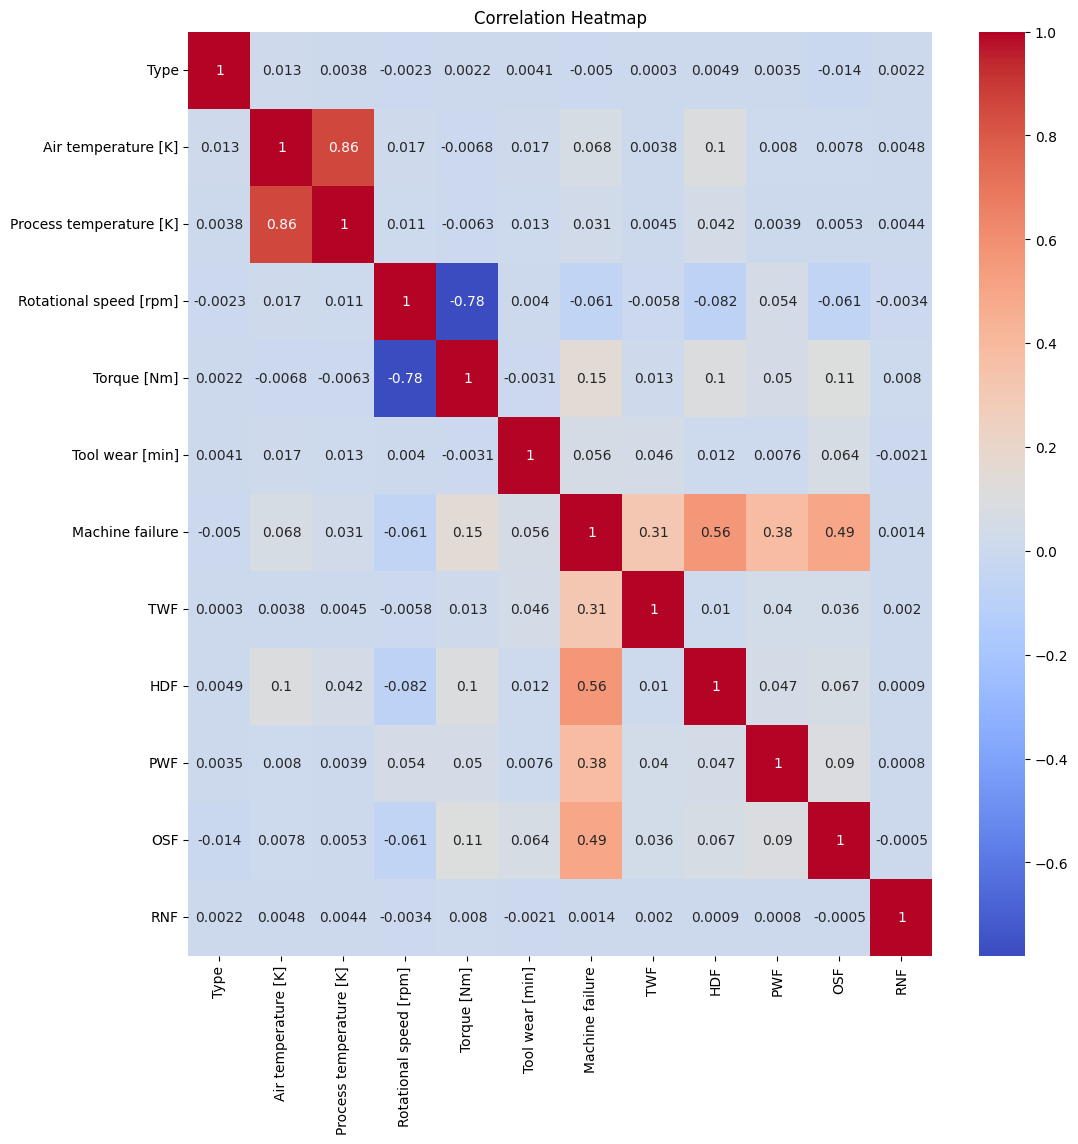

In [125]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Type'] = le.fit_transform(data['Type'])

# drop productid col
data_noprod = data.drop(['Product ID', 'id'], axis=1)

corr = np.round(data_noprod.corr(), 4)
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Modeling

You can use this model or change it to another model you like

In [126]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

predictive_features = ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

train = data[:100_000]
test = data[100_000:]

preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))],
    remainder="passthrough",
)
modeling_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier())])
modeling_pipeline.fit(train[predictive_features], train['Machine failure'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x788966455b90>)])),
                ('classifier', GradientBoostingClassifier())])

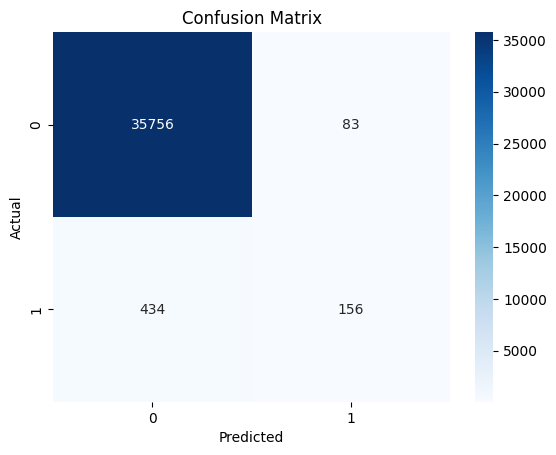

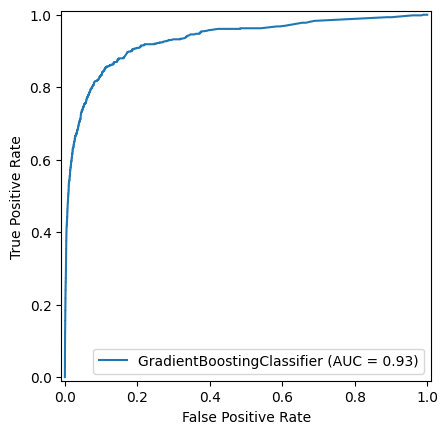

In [127]:
import wandb
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

project_name = 'Decision Optimization Assignment'
# start a new run
run = wandb.init(project=project_name)

# predict labels for test set
test_predictions = modeling_pipeline.predict(test[predictive_features])
test_probabilities = modeling_pipeline.predict_proba(test[predictive_features])[:, 1]

# calculate metrics
conf_mat = confusion_matrix(test['Machine failure'], test_predictions)
accuracy = accuracy_score(test['Machine failure'], test_predictions)
precision = precision_score(test['Machine failure'], test_predictions)
recall = recall_score(test['Machine failure'], test_predictions)
f1 = f1_score(test['Machine failure'], test_predictions)
roc_auc = roc_auc_score(test['Machine failure'], test_probabilities)

# calculate feature importance for tree-based model
feature_importance = modeling_pipeline.named_steps['classifier'].feature_importances_

# Plot confusion matrix with seaborn
fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(test['Machine failure']),
            yticklabels=np.unique(test['Machine failure']))
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")

wandb.log({
    "confusion_matrix": wandb.Image(fig),
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "roc_auc": roc_auc,
    "feature_importance": wandb.Histogram(feature_importance)
})


wandb.log({"accuracy": accuracy})
wandb.log({"precision": precision})
wandb.log({"recall": recall})
wandb.log({"f1": f1})
wandb.log({"roc_auc": roc_auc})
wandb.log({"feature_importance": wandb.Histogram(feature_importance)})

# plot roc curve
fpr, tpr, _ = roc_curve(test['Machine failure'], test_probabilities)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='GradientBoostingClassifier')
roc_display.plot()
plt.savefig("roc_curve.png")

wandb.log({"roc_curve": wandb.Image("roc_curve.png")})

# end run


# Simulation

Your model will predict the likelihood of failure for each row in the data. You will then apply a decision function that considers `Machine Type`` and the probability of failure to decide whether to do preventive maintenance for that machine at that time.

If choose to do preventive maintenance, you pay the cost shown below for `Cost of preventive maintenance` for that machine type. If you don't do maintenance and the observed data in validation is that it failed, then you pay `Cost of failure` for that machine type.

| Machine Type | Cost of preventive maintenance | Cost of failure if you don't do preventive maintenance |
|--------------|--------------------------------|--------------------------------------------------------|
| L            | 1000                           | 30000                                                  |
| M            | 5000                           | 250000                                                 |
| H            | 10000                          | 800000                                                 |

First, write a function that determines the costs given some data, a machine learning model to predict failure rates, and a decision function:

In [128]:
def cost_calculator(data, model, decision_function):
  # 0=L, 1=M, 2=H
  costs = {0: {'p': 1000, 'f': 30000},
           1: {'p': 5000, 'f': 250000},
           2: {'p': 10000, 'f': 800000}}

  total_cost = 0
  decisions = decision_function(data, model)

  for i in range(len(data)):
    machine_type = data['Type'].iloc[i]

    if decisions[i]:
      total_cost += costs[machine_type]['p']
    elif data['Machine failure'].iloc[i] == 1:
      total_cost += costs[machine_type]['f']

  return total_cost


Here is an example decision function.

In [129]:
from quantile_forest import RandomForestQuantileRegressor

qrf = RandomForestQuantileRegressor(
    n_estimators=100, min_samples_leaf=50, random_state=0
)
qrf.fit(train[predictive_features], train['Machine failure'])

RandomForestQuantileRegressor(min_samples_leaf=50, random_state=0)

## Decision Function Comparison: Descriptions and Logic

### 1. `fixed_threshold_decision_function`

**Logic:**  
Classifies a machine for repair if its predicted probability of failure exceeds a fixed threshold.

**Value:**  
- Simple, interpretable baseline.
- Not sensitive to cost or failure severity.
- May under- or over-repair if class imbalance is strong.

---

### 2. `np_quantile_based_decision_function`

**Logic:**  
Sorts all failure probabilities and selects the top 5% riskiest for repair, based on `np.quantile`.

**Value:**  
- Adaptive to distribution.
- Useful when absolute failure probability varies across batches.
- Ignores repair/failure costs.

---

### 3. `quantile_forest_based_decision_function`

**Logic:**  
Uses a quantile regression forest to directly estimate a conservative (e.g., 95th percentile) risk, and repairs machines with predicted risk above a fixed threshold.

**Value:**  
- More robust to uncertainty and skewed risk distributions.
- Uses quantile forest for upper-bound risk.
- Still uses a fixed threshold.

---

### 4. `cost_sensitive_decision_function`

**Logic:**  
Computes expected failure cost using predicted probability, raises it to a risk aversion power `alpha`, and compares it to preventive maintenance cost per machine type.

**Value:**  
- Incorporates real-world cost tradeoffs.
- Handles different machine types and failure impacts.
- `alpha` lets you tune risk sensitivity.

---

### 5. `cost_sensitive_quantile_decision_function`

**Logic:**  
Same idea as `cost_sensitive_decision_function`, but uses quantile-based failure probability estimates instead of mean predictions. This gives a risk-averse cost calculation.

**Value:**  
- Combines the best of both worlds: cost sensitivity and robust quantile estimates.
- Ideal when failure cost is high and uncertainty matters.
- Most advanced and practical strategy in high-risk settings.

---

## Summary Table

| Function Name                         | Uses Quantile? | Cost-Aware? | Risk-Averse? | Key Benefit                           |
|--------------------------------------|----------------|-------------|--------------|----------------------------------------|
| `fixed_threshold_decision_function`  | No             | No          | No           | Simple baseline                        |
| `np_quantile_based_decision_function`| Yes (np)       | No          | Yes (top-k)   | Adaptive threshold                     |
| `quantile_forest_based_decision_function` | Yes (QRF)  | No          | Yes           | Conservative risk from quantile forest |
| `cost_sensitive_decision_function`   | No             | Yes         | Yes (`alpha`) | Cost-optimized decisions               |
| `cost_sensitive_quantile_decision_function` | Yes (QRF) | Yes         | Yes           | Most robust & economically informed    |


In [130]:
def quantile_forest_based_decision_function(data, model, quantile=0.95):
    q95_preds = model.predict(data[predictive_features], quantiles=[quantile])
    repair_decision = q95_preds > 0.05
    return repair_decision

def np_quantile_based_decision_function(data, model, quantile=0.95):
    probability_of_failure = model.predict_proba(data[predictive_features])[:, 1]
    threshold = np.quantile(probability_of_failure, 0.95)
    repair_decision = probability_of_failure > threshold
    return repair_decision

def fixed_threshold_decision_function(data, model, fixed_decision_threshold=0.01):
    probability_of_failure = model.predict_proba(data[predictive_features])[:, 1]
    repair_decision = probability_of_failure > fixed_decision_threshold
    return repair_decision

def cost_sensitive_decision_function(data, model,quantile=0.95,alpha=1.5):
    probability_of_failure = model.predict_proba(data[predictive_features])[:, 1]

    preventive_cost = {0: 1000, 1: 5000, 2: 10000}
    failure_cost = {0: 30000, 1: 250000, 2: 800000}

    repair_decision = []
    idx = 0
    for i, row in data.iterrows():
      m_type = row['Type']
      p_fail = probability_of_failure[idx]
      idx += 1
      expected_failure_cost = (p_fail ** alpha) * failure_cost[m_type]
      if expected_failure_cost > preventive_cost[m_type]:
          repair_decision.append(True)
      else:
          repair_decision.append(False)

    return np.array(repair_decision)

def cost_sensitive_quantile_decision_function(data, model, quantile=0.95, alpha=1.5):
    q_risks = model.predict(data[predictive_features], quantiles=[quantile])

    preventive_cost = {0: 1000, 1: 5000, 2: 10000}
    failure_cost = {0: 30000, 1: 250000, 2: 800000}

    repair_decision = [
        (p_fail_q ** alpha) * failure_cost[m_type] > preventive_cost[m_type]
        for p_fail_q, m_type in zip(q_risks, data['Type'])
    ]

    return np.array(repair_decision)


fixed_cost = cost_calculator(test, modeling_pipeline, fixed_threshold_decision_function)
cost_sensitive = cost_calculator(test, modeling_pipeline, cost_sensitive_decision_function)
np_quantile = cost_calculator(test, qrf, quantile_forest_based_decision_function)
quantile_forest = cost_calculator(test, qrf, quantile_forest_based_decision_function)
cost_sensitive_quantile = cost_calculator(test, qrf, cost_sensitive_quantile_decision_function)

#print all
print("Quantile Forest: ", quantile_forest)
print("Fixed Threshold: ", fixed_cost)
print("Cost Sensitive: ", cost_sensitive)
print("Numpy Quantile: ", np_quantile)
print("Cost Sensitive Quantile: ", cost_sensitive_quantile)

#log all to wandb
wandb.log({"quantile_forest": quantile_forest})
wandb.log({"fixed_cost": fixed_cost})
wandb.log({"cost_sensitive": cost_sensitive})
wandb.log({"np_quantile": np_quantile})
wandb.log({"cost_sensitive_quantile": cost_sensitive_quantile})

Quantile Forest:  62086000
Fixed Threshold:  57272000
Cost Sensitive:  74888000
Numpy Quantile:  62086000
Cost Sensitive Quantile:  62086000


In [131]:
# Define custom x-axis
wandb.define_metric("quantile")
wandb.define_metric("quantile_forest_cost", step_metric="quantile")
wandb.define_metric("np_quantile_cost", step_metric="quantile")
wandb.define_metric("fixed_threshold_cost", step_metric="quantile")
wandb.define_metric("cost_sensitive_cost", step_metric="quantile")
wandb.define_metric("cost_sensitive_quantile_cost", step_metric="quantile")

# Define parameter ranges
quantile_values = np.arange(0.85, 0.96, 0.01)
alpha_values = np.arange(1.5, 2.1, 0.1)

# Iterate over parameter combinations
for quantile in quantile_values:
    for alpha in alpha_values:
        # Compute costs using your cost_calculator function
        quantile_forest_cost = cost_calculator(test, qrf, lambda data, model: quantile_forest_based_decision_function(data, model, quantile=quantile))
        np_quantile_cost = cost_calculator(test, modeling_pipeline, lambda data, model: np_quantile_based_decision_function(data, model, quantile=quantile))
        fixed_threshold_cost = cost_calculator(test, modeling_pipeline, lambda data, model: fixed_threshold_decision_function(data, model, fixed_decision_threshold=0.01))
        cost_sensitive_cost = cost_calculator(test, modeling_pipeline, lambda data, model: cost_sensitive_decision_function(data, model, alpha=alpha))
        cost_sensitive_quantile_cost = cost_calculator(test, qrf, lambda data, model: cost_sensitive_quantile_decision_function(data, model, quantile=quantile, alpha=alpha))

        # Log metrics
        wandb.log({
            "quantile": quantile,
            "alpha": alpha,
            "quantile_forest_cost": quantile_forest_cost,
            "np_quantile_cost": np_quantile_cost,
            "fixed_threshold_cost": fixed_threshold_cost,
            "cost_sensitive_cost": cost_sensitive_cost,
            "cost_sensitive_quantile_cost": cost_sensitive_quantile_cost
        })

Once you have created and compared at least three decision functions, you can create and submit your report comparing them. Remember to describe (in a sentence or two) your plan for dealing with the covariate shift and testing issues described at the top of this assignment.

Good Luck!

In [132]:
run.finish()


accuracy,▁▁
alpha,▁▂▃▄▆▁▂▄▆▇▁▂▃▆█▄▆▇█▇▁▂▃▇█▃▆▁▄▇▃▆▇█▃▆█▁▄█
cost_sensitive,▁
cost_sensitive_cost,▁▂▄█▁▅▆█▁▃▅▆▁▂▄▂▅▆▂▄█▁▄▁▂▄▆▁▃▄▆█▁▂▃▅▁▂▃█
cost_sensitive_quantile,▁
cost_sensitive_quantile_cost,█████████▇▇▇▆▆▆▇▇▆▆▆▅▅▆▆▄▅▅▅▃▃▄▄▂▂▂▂▁▁▁▁
f1,▁▁
fixed_cost,▁
fixed_threshold_cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
np_quantile,▁
np_quantile_cost,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


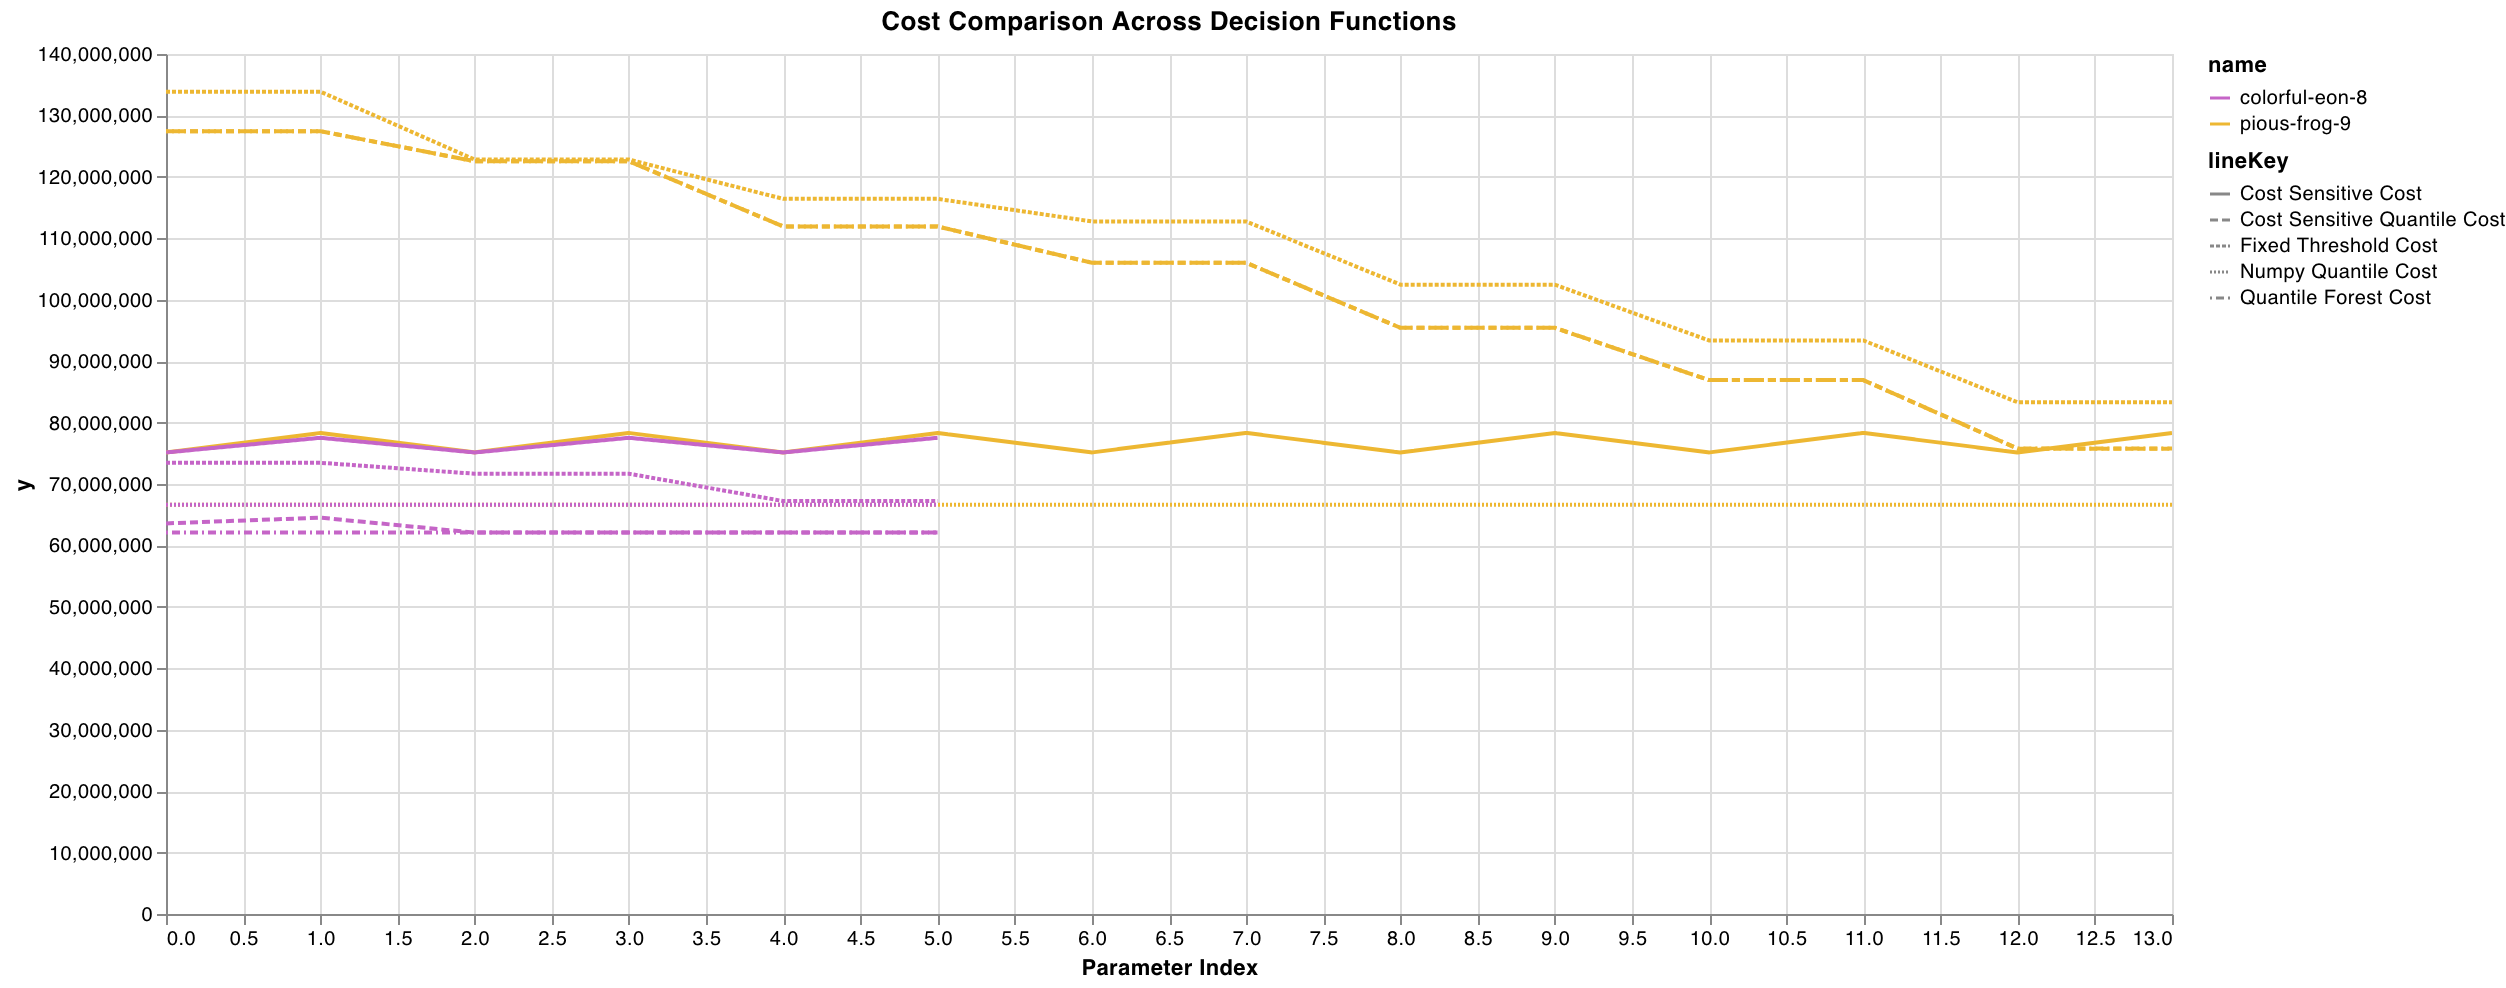